In [43]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
from collections import defaultdict, namedtuple, Counter
from itertools import combinations
import numpy as np
import scipy.stats as stats
import sys
from os import listdir
import json
import argparse
import random
import scipy.sparse as sparse

# Permutation Test

In [259]:
permutation_results = '../permutation_tests/spark+ancestry'
z0 = np.load('%s.0.npy' % permutation_results)
chroms0 = np.load('%s.0.chroms.npy' % permutation_results)
intervals0 = np.load('%s.0.intervals.npy' % permutation_results)
actual0 = np.load('%s.0.actual.npy' % permutation_results)

#z1 = np.load('%s.1.npy' % permutation_results)
#chroms1 = np.load('%s.1.chroms.npy' % permutation_results)
#intervals1 = np.load('%s.1.intervals.npy' % permutation_results)
#actual1 = np.load('%s.1.actual.npy' % permutation_results)

#z2 = np.load('%s.2.npy' % permutation_results)
#chroms2 = np.load('%s.2.chroms.npy' % permutation_results)
#intervals2 = np.load('%s.2.intervals.npy' % permutation_results)
#actual2 = np.load('%s.2.actual.npy' % permutation_results)

In [260]:
print(chroms0.shape, chroms2.shape)

(14823,) (235,)


In [261]:
with open('../data/chrom_lengths38.json', 'r') as f:
    chrom_lengths = json.load(f)
offset = np.zeros((23,), dtype=int)
for ch in range(1, 23):
    offset[(ch+1):] += chrom_lengths[str(ch)]
x0 = np.array([offset[int(ch)]+p for ch, p in zip(chroms0, intervals0[0, :])])
x2 = np.array([offset[int(ch)]+p for ch, p in zip(chroms2, intervals2[0, :])])

In [262]:
cutoff0 = np.quantile(z0, 0.95)
cutoff2 = np.quantile(z2, 0.95)
print(cutoff0)

60.0


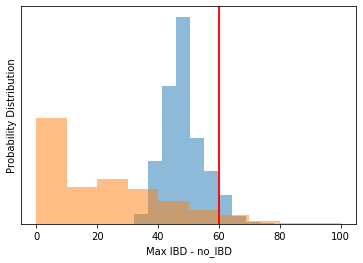

In [263]:
plt.hist(z0, alpha=0.5, density=True)
plt.hist(z2, alpha=0.5, density=True)
plt.axvline(cutoff0, color='red')
plt.axvline(cutoff2, color='red')
plt.xlabel('Max IBD - no_IBD')
plt.yticks([])
plt.ylabel('Probability Distribution')
plt.show()

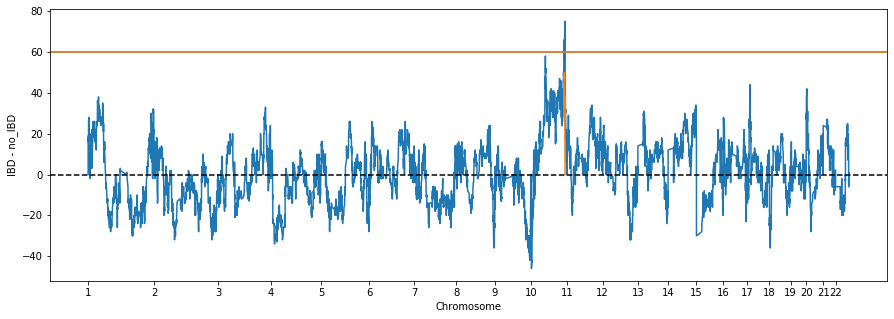

In [264]:
plt.figure(figsize=(15, 5))

#plt.subplot(3, 1, 1)
p = plt.plot(x0, actual0)
plt.axhline(cutoff0, color=p[0].get_color())

p = plt.plot(x2, actual2)
plt.axhline(cutoff2, color=p[0].get_color())

plt.axhline(0, color='black', linestyle='--')
plt.xticks(offset[1:], [str(x) for x in range(1, 23)])
plt.xlabel('Chromosome')
plt.ylabel('IBD - no_IBD')

plt.show()

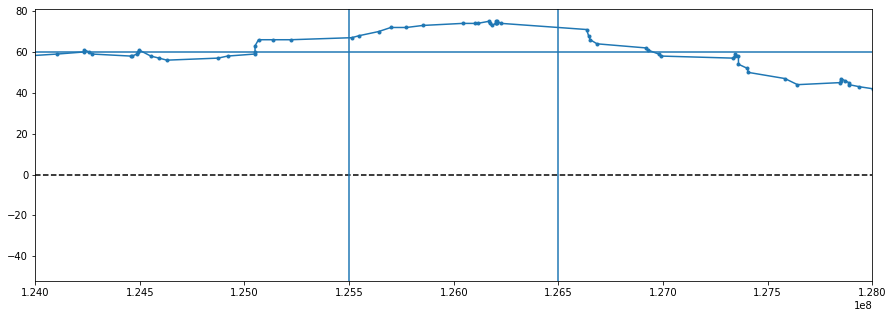

In [266]:
plt.figure(figsize=(15, 5))

p = plt.plot(intervals0[0, chroms0==10], actual0[chroms0==10], marker='.')
plt.axhline(cutoff0, color=p[0].get_color())

#p = plt.plot(intervals2[0, chroms2==10], actual2[chroms2==10], marker='.')
#plt.axhline(cutoff2, color=p[0].get_color())
plt.xlim([124000000, 128000000])
plt.axhline(0, color='black', linestyle='--')
#plt.xlim([123796859-1000000, 126684943+1000000])
plt.axvline(125500000)
plt.axvline(126500000)

plt.axclin()

plt.show()

In [251]:
print('pvalue', np.sum(z0>=np.max(actual0))/len(z0))

pvalue 0.001


In [278]:
sig_start = intervals0[0, chroms0==10][actual0[chroms0==10]>=cutoff0][0]
sig_end = intervals0[1, chroms0==10][actual0[chroms0==10]>=cutoff0][-1]

print(sig_start, sig_end, sig_end-sig_start)


123199058 126979126 3780068


In [253]:
exome_targets = []
with open('../../FamilySeqError/data/VCRome_2.1_design_files/VCRome_2_1_hg38_primary_targets_liftover_ordered.bed', 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        s, e = int(pieces[1]), int(pieces[2])
        if pieces[0]=='chr10' and (min(sig_end+1000000, e)-max(sig_start-1000000, s) > 0):
            exome_targets.append((s, e))

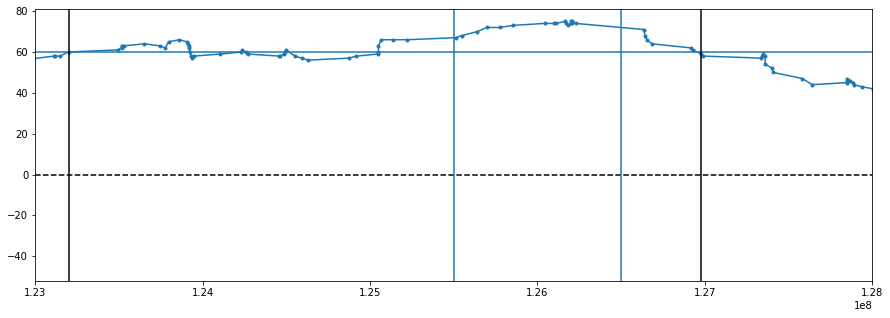

In [277]:
plt.figure(figsize=(15, 5))

p = plt.plot(intervals0[0, chroms0==10], actual0[chroms0==10], marker='.')
plt.axhline(cutoff0, color=p[0].get_color())

#p = plt.plot(intervals2[0, chroms2==10], actual2[chroms2==10], marker='.')
#plt.axhline(cutoff2, color=p[0].get_color())
plt.xlim([123000000, 128000000])
plt.axhline(0, color='black', linestyle='--')
#plt.xlim([123796859-1000000, 126684943+1000000])
plt.axvline(125500000)
plt.axvline(126500000)
plt.axvline(sig_start, color='black')
plt.axvline(sig_end, color='black')

#for s, e in exome_targets:
#    plt.plot([s, e], [0, 0], color='red', linewidth=20)


plt.show()

# Ancestry Validation

In [92]:
#permutation_results = '../permutation_tests/ihart.chr10.123796859-126917556'
#permutation_results = '../permutation_tests/mssng.chr10.123796859-126917556'
#permutation_results = '../permutation_tests/spark.exome_missing_parent.chr10.123796859-126917556'
#permutation_results = '../permutation_tests/spark.exome.chr10.123796859-126917556'
#permutation_results = '../permutation_tests/ssc.chr10.123796859-126917556'

#permutation_results = '../permutation_tests/ihart_nopass.chr10.123796859-126917556'
permutation_results = '../permutation_tests/mssng_common.chr10.123796859-126917556'


In [93]:
try:
    z0 = np.load('%s.0.npy' % permutation_results)
    chroms0 = np.load('%s.0.chroms.npy' % permutation_results)
    intervals0 = np.load('%s.0.intervals.npy' % permutation_results)
    actual0 = np.load('%s.0.actual.npy' % permutation_results)
    actual0_IBD = np.load('%s.0.actual_IBD.npy' % permutation_results)
    actual0_noIBD = np.load('%s.0.actual_noIBD.npy' % permutation_results)
    cutoff0 = np.quantile(z0, 0.95)
except:
    z0 = []
    chroms0 = []
    intervals0 = []
    actual0 = []
    cutoff0 = 0

z1 = np.load('%s.1.npy' % permutation_results)
chroms1 = np.load('%s.1.chroms.npy' % permutation_results)
intervals1 = np.load('%s.1.intervals.npy' % permutation_results)
actual1 = np.load('%s.1.actual.npy' % permutation_results)
cutoff1 = np.quantile(z1, 0.05)
actual1_IBD = np.load('%s.1.actual_IBD.npy' % permutation_results)
actual1_noIBD = np.load('%s.1.actual_noIBD.npy' % permutation_results)

try:
    z2 = np.load('%s.2.npy' % permutation_results)
    chroms2 = np.load('%s.2.chroms.npy' % permutation_results)
    intervals2 = np.load('%s.2.intervals.npy' % permutation_results)
    actual2 = np.load('%s.2.actual.npy' % permutation_results)
    actual2_IBD = np.load('%s.2.actual_IBD.npy' % permutation_results)
    actual2_noIBD = np.load('%s.2.actual_noIBD.npy' % permutation_results)
    cutoff2 = np.quantile(z2, 0.95)
except:
    z2 = []
    chroms2 = []
    intervals2 = []
    actual2 = []
    cutoff2 = 0


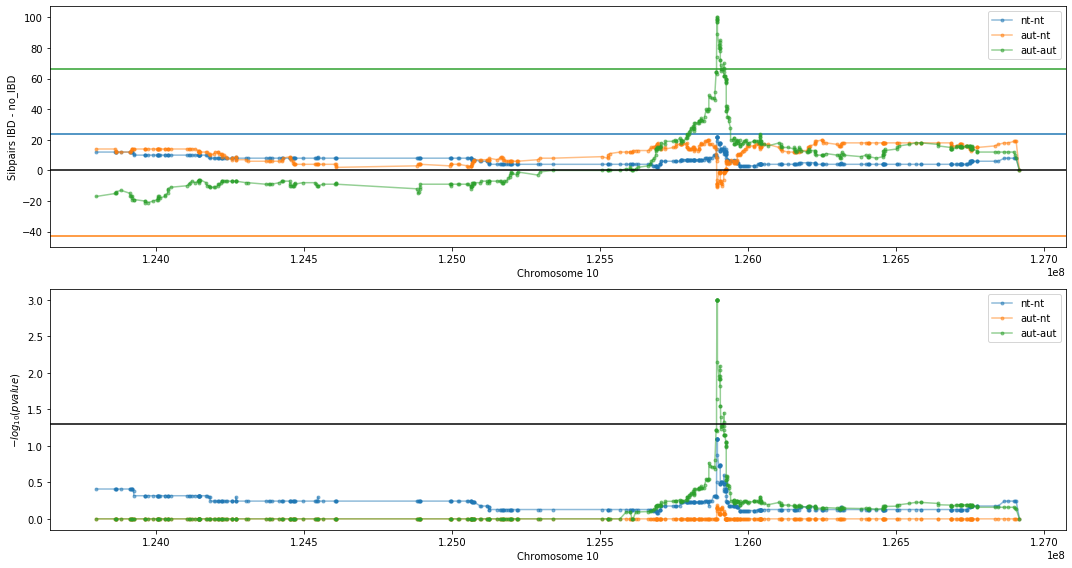

In [99]:
plt.figure(figsize=(15, 8))

plt.subplot(2, 1, 1)
if len(z0)>0:
    p = plt.plot(intervals0[0, :], actual0, label='nt-nt', alpha=0.5, marker='.')
    plt.axhline(cutoff0, color=p[0].get_color())
p = plt.plot(intervals1[0, :], actual1, label='aut-nt', alpha=0.5, marker='.')
plt.axhline(cutoff1, color=p[0].get_color())
if len(z2)>0:
    p = plt.plot(intervals2[0, :], actual2, label='aut-aut', alpha=0.5, marker='.')
    plt.axhline(cutoff2, color=p[0].get_color())
plt.legend()
plt.axhline(0, color='black')
plt.ylabel('Sibpairs IBD - no_IBD')
plt.xlabel('Chromosome 10')

plt.subplot(2, 1, 2)
if len(z0)>0:
    plt.plot(intervals0[0, :], -np.log10([np.sum(z0>=a)/len(z0) for a in actual0]), label='nt-nt', alpha=0.5, marker='.')
plt.plot(intervals1[0, :], -np.log10([np.sum(z1<=a)/len(z1) for a in actual1]), label='aut-nt', alpha=0.5, marker='.')
if len(z2)>0:
    plt.plot(intervals2[0, :], -np.log10([np.sum(z2>=a)/len(z2) for a in actual2]), label='aut-aut', alpha=0.5, marker='.')

plt.legend()
plt.axhline(-np.log10(0.05), color='black')
plt.ylabel('$-log_{10}(pvalue)$')
plt.xlabel('Chromosome 10')

plt.tight_layout()
plt.show()


In [100]:
assert np.all(intervals0==intervals1)
assert np.all(intervals0==intervals2)
chi2_pvalues = np.ones(actual0.shape)

for i in range(actual0.shape[0]):
    try:
        chi2_pvalues[i] = stats.chi2_contingency([[actual0_IBD[i], actual0_noIBD[i]],
                                              [actual1_IBD[i], actual1_noIBD[i]],
                                              [actual2_IBD[i], actual2_noIBD[i]]])[1]
        
    except:
        pass

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in true_divide


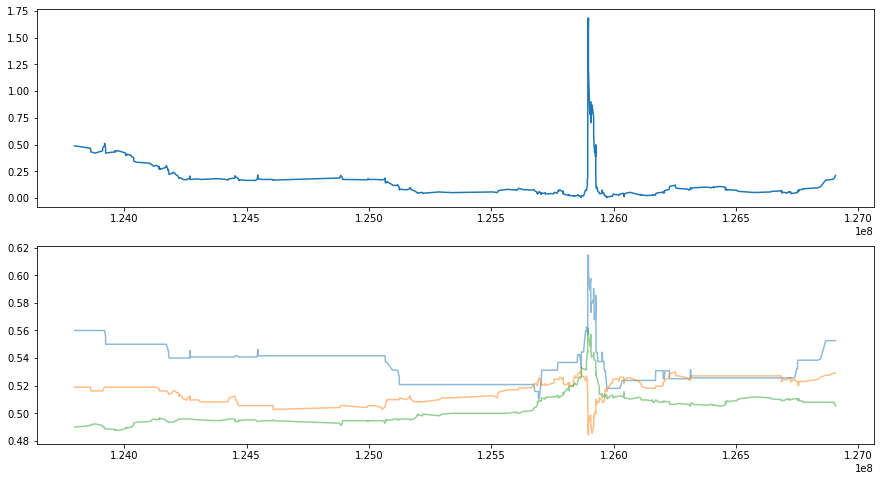

In [101]:
plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.plot(intervals0[0, :], -np.log10(chi2_pvalues))
#plt.scatter(intervals0[0, :], -np.log10(chi2_pvalues_phen))
plt.subplot(2, 1, 2)
plt.plot(intervals0[0, :], actual0_IBD/(actual0_IBD+actual0_noIBD), alpha=0.5)
plt.plot(intervals1[0, :], actual1_IBD/(actual1_IBD+actual1_noIBD), alpha=0.5)
plt.plot(intervals2[0, :], actual2_IBD/(actual2_IBD+actual2_noIBD), alpha=0.5)
plt.show()

# Figuring out GC

In [455]:
import statsmodels.api as sm

model = sm.MNLogit(np.hstack((num_affected, num_affected)), np.hstack((shared[:, np.newaxis], np.hstack((num_males, num_males))[:, np.newaxis]==2, np.hstack((num_males, num_males))[:, np.newaxis]==1, np.ones((shared.shape[0], 1)))))
result = model.fit()
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.801571
         Iterations 7
                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                 1474
Model:                        MNLogit   Df Residuals:                     1466
Method:                           MLE   Df Model:                            6
Date:                Wed, 07 Apr 2021   Pseudo R-squ.:                 0.03768
Time:                        21:50:10   Log-Likelihood:                -1181.5
converged:                       True   LL-Null:                       -1227.8
Covariance Type:            nonrobust   LLR p-value:                 9.104e-18
       y=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -8.849e-06   4.29e-06     -2.063      0.039   -1.73e-05   -4.43e-07
x2             1.5597      0.

In [461]:
import statsmodels.api as sm

y = np.hstack(([x.sibling1_aff for x in sibpairs_of_interest], [x.sibling1_aff for x in sibpairs_of_interest]))
X = np.hstack((shared[:, np.newaxis], 
                            np.hstack(([x.sibling1_male for x in sibpairs_of_interest], [x.sibling1_male for x in sibpairs_of_interest]))[:, np.newaxis], 
                            np.hstack(([x.sibling2_male for x in sibpairs_of_interest], [x.sibling2_male for x in sibpairs_of_interest]))[:, np.newaxis], 
                            np.hstack(([x.sibling2_aff for x in sibpairs_of_interest], [x.sibling2_aff for x in sibpairs_of_interest]))[:, np.newaxis], 
                            np.ones((shared.shape[0], 1))))

# predict of siblings of autistic children have autism
model = sm.Logit(y[X[:, 3]==1], X[X[:, 3]==1, :][:, [0, 1, 2, 4]])
result = model.fit()
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.111998
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  978
Model:                          Logit   Df Residuals:                      974
Method:                           MLE   Df Model:                            3
Date:                Wed, 07 Apr 2021   Pseudo R-squ.:                 0.02793
Time:                        21:55:05   Log-Likelihood:                -109.53
converged:                       True   LL-Null:                       -112.68
Covariance Type:            nonrobust   LLR p-value:                   0.09810
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -4.362e-06   8.06e-06     -0.541      0.589   -2.02e-05    1.14e-05
x2             1.0453      0.

In [462]:
# predict if siblings of nt children have autism
model = sm.Logit(y[X[:, 3]==0], X[X[:, 3]==0, :][:, [0, 1, 2, 4]])
result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.454273
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  496
Model:                          Logit   Df Residuals:                      492
Method:                           MLE   Df Model:                            3
Date:                Wed, 07 Apr 2021   Pseudo R-squ.:                  0.1496
Time:                        21:55:10   Log-Likelihood:                -225.32
converged:                       True   LL-Null:                       -264.94
Covariance Type:            nonrobust   LLR p-value:                 4.451e-17
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          -1.08e-05   4.71e-06     -2.292      0.022      -2e-05   -1.57e-06
x2             2.0271      0.

In [275]:
data_dir = '../../DATA/mssng/genotypes'
ped_file = '../../DATA/mssng/mssng.ped.quads.ped'
start_pos, end_pos = 125880000, 125930000

gen_files = sorted([f for f in listdir(data_dir) if ('chr.%s.' % chrom) in f and 'gen.npz' in f], key=lambda x: int(x.split('.')[2]))
coord_files = sorted([f for f in listdir(data_dir) if ('chr.%s.' % chrom) in f and 'gen.coordinates.npy' in f], key=lambda x: int(x.split('.')[2]))
sample_file = '%s/samples.json' % data_dir

# read samples
with open(sample_file, 'r') as f:
    samples = json.load(f)
    sample_id_to_index = dict([(x, i) for i, x in enumerate(samples)])

indices = np.array([(sample_id_to_index[sp.mom], sample_id_to_index[sp.dad], 
                     sample_id_to_index[sp.sibling1], sample_id_to_index[sp.sibling2]) for sp in sibpairs_of_interest])

gens, snp_positions = [], []
total_pos = 0
for gen_file, coord_file in zip(gen_files, coord_files):
    coords = np.load('%s/%s' % (data_dir, coord_file))

    if coords.shape[0]>0:
        poss = coords[:, 1]
        is_snp = coords[:, 2]==1
        is_pass = coords[:, 3]==1

        in_interval = (coords[:, 1]>=start_pos) & (coords[:, 1]<=end_pos)
        if np.sum(is_snp & is_pass & in_interval)>0:
            gen = sparse.load_npz('%s/%s' % (data_dir, gen_file))[:, in_interval].A[indices, :]
            gens.append(gen)
            snp_positions.append(poss[in_interval])

gens = np.hstack(gens)
snp_positions = np.hstack(snp_positions)
print(gens.shape, snp_positions.shape)


(737, 4, 5015) (5015,)


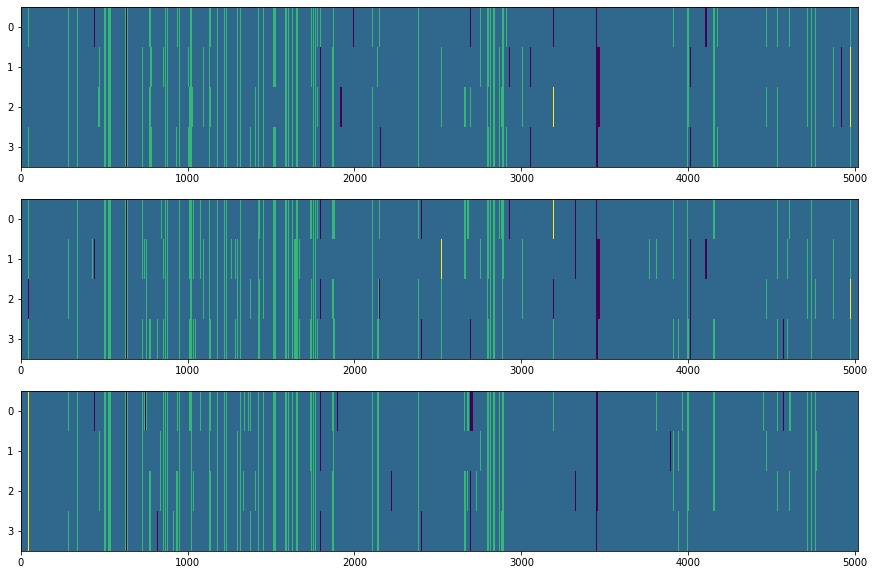

In [282]:

plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
index = np.random.randint(0, np.sum(num_affected==0))
plt.imshow(gen[num_affected==0, :][index, :], aspect='auto')

plt.subplot(3, 1, 2)
index = np.random.randint(0, np.sum(num_affected==1))
plt.imshow(gen[num_affected==1, :][index, :], aspect='auto')

plt.subplot(3, 1, 3)
index = np.random.randint(0, np.sum(num_affected==2))
plt.imshow(gen[num_affected==2, :][index, :], aspect='auto')

plt.show()

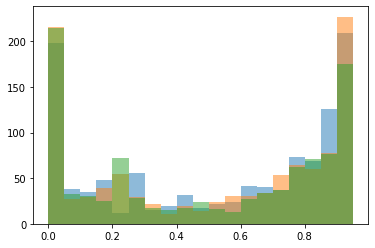

In [272]:
plt.hist(np.sum((gens[num_affected==0, 0, :]==0) & (gens[num_affected==0, 1, :]==0), axis=0)/np.sum(num_affected==0), alpha=0.5, bins=np.arange(0, 1, 0.05))
plt.hist(np.sum((gens[num_affected==1, 0, :]==0) & (gens[num_affected==1, 1, :]==0), axis=0)/np.sum(num_affected==1), alpha=0.5, bins=np.arange(0, 1, 0.05))
plt.hist(np.sum((gens[num_affected==2, 0, :]==0) & (gens[num_affected==2, 1, :]==0), axis=0)/np.sum(num_affected==2), alpha=0.5, bins=np.arange(0, 1, 0.05))

plt.show()

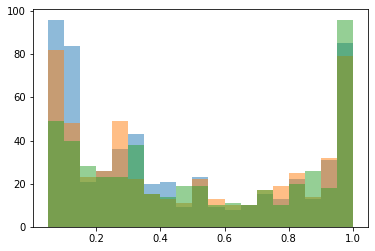

In [274]:
plt.hist(np.sum((gens[num_affected==0, 0, :]==1) & (gens[num_affected==0, 1, :]==1), axis=0)/np.sum(num_affected==0), alpha=0.5, bins=np.arange(0.05, 1.05, 0.05))
plt.hist(np.sum((gens[num_affected==1, 0, :]==1) & (gens[num_affected==1, 1, :]==1), axis=0)/np.sum(num_affected==1), alpha=0.5, bins=np.arange(0.05, 1.05, 0.05))
plt.hist(np.sum((gens[num_affected==2, 0, :]==1) & (gens[num_affected==2, 1, :]==1), axis=0)/np.sum(num_affected==2), alpha=0.5, bins=np.arange(0.05, 1.05, 0.05))

plt.show()

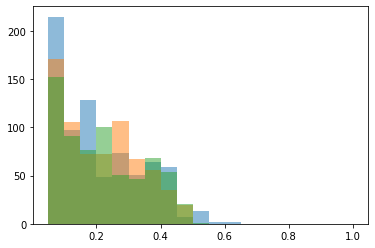

In [270]:
plt.hist(np.sum(((gens[num_affected==0, 0, :]==0) & (gens[num_affected==0, 1, :]==1)) | ((gens[num_affected==0, 0, :]==1) & (gens[num_affected==0, 1, :]==0)), axis=0)/np.sum(num_affected==0), alpha=0.5, bins=np.arange(0.05, 1.05, 0.05))
plt.hist(np.sum(((gens[num_affected==1, 0, :]==0) & (gens[num_affected==1, 1, :]==1)) | ((gens[num_affected==1, 0, :]==1) & (gens[num_affected==1, 1, :]==0)), axis=0)/np.sum(num_affected==1), alpha=0.5, bins=np.arange(0.05, 1.05, 0.05))
plt.hist(np.sum(((gens[num_affected==2, 0, :]==0) & (gens[num_affected==2, 1, :]==1)) | ((gens[num_affected==2, 0, :]==1) & (gens[num_affected==2, 1, :]==0)), axis=0)/np.sum(num_affected==2), alpha=0.5, bins=np.arange(0.05, 1.05, 0.05))

plt.show()

In [186]:
print(interval_bins_val[actual>=np.quantile(z, 0.95)])

[125880401 125880533 125880722 125881178 125881863 125882496 125884204
 125884446 125885273 125885447 125885978 125886197 125887621 125888061
 125888233 125888240 125888243 125888718 125889474 125889512 125890484
 125890771 125890990 125891138 125892202 125892203 125892446 125893451
 125893653 125893654 125893968 125894180 125894199 125894280 125894783
 125894784 125895919 125895978 125896024 125896611 125897454 125897455
 125898041 125898101 125898398 125898578 125899776 125900367 125900368
 125900376 125901215 125901395 125901507 125903514 125903515 125903817
 125903975 125904174 125904846 125904892 125905265 125905266 125905304
 125905305 125905373 125905425 125905976 125906119 125906363 125906410
 125906411 125906548 125906608 125906832 125907151 125907251 125907536
 125907906 125907993 125909245 125910310 125910963 125916913 125917966
 125917991 125917992 125918596 125918693 125918694 125918843 125918924
 125919698 125919771 125920553 125920708 125921148 125923829 125924307
 12592

In [169]:
print(interval_bins_val[actual>=np.quantile(z, 0.9)])

[125880401 125880533 125880722 125881178 125881863 125882496 125884204
 125884446 125885273 125885447 125885978 125886197 125887621 125888240
 125888243 125888718 125889512 125890771 125890990 125891138 125892202
 125892203 125892446 125893451 125893653 125893654 125893968 125894199
 125894280 125894783 125894784 125895919 125895978 125896024 125896611
 125897454 125897455 125898041 125898101 125898398 125898578 125899776
 125900376 125901215 125901395 125901507 125903514 125903515 125903817
 125903975 125904174 125904846 125904892 125905266 125905304 125905305
 125905373 125905976 125906119 125906410 125906411 125906548 125906608
 125906832 125907536 125907906 125907993 125909245 125910310 125910963
 125916913 125917966 125917991 125917992 125918693 125918694 125918843
 125919771 125920553 125921148 125923829 125924307 125925260 125926357
 125926358 125926468 125926469 125926492]


In [158]:
print(interval_bins_val[actual>=np.quantile(z, 0.9)])

[125894783 125896611 125897454 125900367 125900368 125901507 125903975
 125905265 125905304]


# Markov Chain

In [ ]:
n = 112 + 55
t = 10000*n

a = np.random.rand(t)
obs = np.zeros((t,), dtype=int)
obs[0] = n/2
for i in range(1, t):
    if a[i] < (n-obs[i-1])/n:
        obs[i] = obs[i-1]+1
    else:
        obs[i] = obs[i-1]-1

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(obs)
plt.axhline(n/2, color='black', linestyle='--')
plt.show()

In [ ]:
plt.hist(obs, bins=np.arange(60, 120))
plt.axvline(112)
plt.show()

In [ ]:
P = np.zeros((n+1,n+1))
for i in range(n+1):
    if i+1<n+1:
        P[i, i+1] = (n-i)/n
    if i-1>=0:
        P[i, i-1] = i/n
assert np.all(np.isclose(np.sum(P, axis=1), 1))
print(P)

In [ ]:
eigval, eigvec = scipy.linalg.eig(P, left=True, right=False)
print(eigval[0])
stationary = eigvec[:, 0]/np.sum(eigvec[:, 0])
stationary[stationary<0] = 0
stationary = stationary/np.sum(stationary)

In [ ]:
min_bound = np.argmax(np.cumsum(stationary)>0.025)
max_bound = n-np.argmax(np.cumsum(np.flip(stationary))>0.025)
print(min_bound, max_bound)

In [ ]:
plt.plot(stationary)
plt.axvline(min_bound)
plt.axvline(max_bound)
plt.show()

In [ ]:
print(np.sum(stationary[112:]))

In [ ]:
plt.plot(-np.log10(stationary))
plt.axhline(-np.log10(0.05))
plt.show()